# Experiment for Use Case 1
In this experiment, we analyze the effect of two optimizations from the paper:

O1. exact_reuse of operations that (input_columns, and edge type)

O3. wamrstarting when the model and the input columns are the same but the hyperparameters are different.

In this experiment, we still do not operate on a per column granularity. 
For OpenML this should be fine, as most of the pipelines that we utilize in the experiment are operating on the entire data.
 

In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyperopt import fmin, tpe, Trials
from openml import datasets, tasks, flows, config

from openmlstudy14.preprocessing import ConditionalImputer
from workloadoptimization.essentials import Component, ExperimentParser
from workloadoptimization.hyperopt_helper import TrialConverter
from workloadoptimization.openml_helper import OpenMLReader
from workloadoptimization.search_space import SearchSpaceDesigner
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

In [3]:
flow_ids = [8568] # Random forsst with warmstarting
task_ids = [31]

In [6]:
# load the dataset
task = tasks.get_task(task_id=31)
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices,test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
target=dataset.default_target_attribute,
return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [7]:
def extract_experiments(file_path, task_ids, flow_ids):
    openMLReader = OpenMLReader()
    if os.path.isfile(file_path):
        return pd.read_pickle(file_path)
    frames = []
    for t in task_ids:
        for f in flow_ids:
            frames.append(openMLReader.getTopRuns(-1, f, t))
    Experiments = pd.concat(frames).reset_index(drop=True)
    Experiments.to_pickle(file_path)
    return Experiments


# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extract_experiments('meta/hyper-opt-experiment-31-all', task_ids, flow_ids)
Experiments = Experiments[Experiments.flow_id == flow_ids]

In [8]:
OPENML_FLOWS = {}
FLOW_IDS = Experiments.flow_id.unique()
for f in FLOW_IDS:
    try:
        # print f
        fl = flows.get_flow(f)
        OPENML_FLOWS[f] = fl
    except:
        print 'error for {}'.format(f)
parser = ExperimentParser()
experimentObjects = parser.extractOpenMLFlows(Experiments, OPENML_FLOWS)


In [9]:
# load the dataset
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices, test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
    target=dataset.default_target_attribute,
    return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [10]:
def objective(pipeline, params):
    print '.',
    # seems when tol is big (greater than 1) scikit learn throws an exception
    # I couldn't find a way to cap a value in the search space of hyperopt, 
    # this is the alternative solution
    # if params['classifier__tol'] > 0.2:
    #    params['classifier__tol'] = 0.2
    pipeline.set_params(**params)
    try:
        pipeline.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
    accuracy = pipeline.score(X_test, y_test)
    # print 'accuracy = {}'.format(accuracy)
    return 1 - accuracy

In [11]:
flow = flows.get_flow(flow_id=flow_ids[0])
# Hack for the non existing arbok.preprocessing.ConditionalImputer Class
flow.components['conditionalimputer'].class_name = 'hyperimp.utils.preprocessing.ConditionalImputer2'
pipeline = flows.flow_to_sklearn(flow)

In [12]:
for k in experimentObjects[0].extractParams().keys():
    if k != 'onehotencoder__categorical_features' and k != 'conditionalimputer__categorical_features' and not k.startswith('randomforestclassifier'):
        a = []
        for e in experimentObjects:
            a.append(e.extractParams()[k])
        print(k, [[x, a.count(x)] for x in set(a)])


('onehotencoder__n_values', [['auto', 555]])
('conditionalimputer__verbose', [[0, 555]])
('conditionalimputer__strategy', [['most_frequent', 136], ['median', 163], ['mean', 256]])
('onehotencoder__dtype', [[<type 'numpy.float64'>, 555]])
('variancethreshold__threshold', [[0.0, 555]])
('onehotencoder__sparse', [[False, 201], [True, 354]])
('onehotencoder__handle_unknown', [['ignore', 555]])
('conditionalimputer__missing_values', [['NaN', 555]])
('conditionalimputer__fill_empty', [[0, 555]])
('conditionalimputer__copy', [[True, 555]])
('conditionalimputer__axis', [[0, 555]])
('conditionalimputer__strategy_nominal', [['most_frequent', 555]])


In [13]:
# the pipeline configuration that has the highest nuber of exeuction = 152
filteredObjects = []
for e in experimentObjects:
    if e.extractParams()['conditionalimputer__strategy'] == 'mean' and e.extractParams()['onehotencoder__sparse']:
        filteredObjects.append(e)   

In [24]:
import copy
import warnings
warnings.filterwarnings('ignore')
baseline = []
# Baseline 
for e in filteredObjects:
    start = time.time()
    params = e.extractParams()
    params['randomforestclassifier__warm_start'] = False
    quality = objective(pipeline, params)
    end = time.time()
    time_to_converge_baseline = end - start
    baseline.append(time_to_converge_baseline)
    
# Optimized
# reinitialize the pipeline (model parameters)
pipeline = flows.flow_to_sklearn(flow)
optimized = []
best_pipeline = copy.deepcopy(pipeline)
best_quality = 0.0
for e in filteredObjects:
    start = time.time()
    params = e.extractParams()
    params['randomforestclassifier__warm_start'] = True
    # warm start the model to the best existing model
    pipeline = copy.deepcopy(best_pipeline)
    quality = objective(pipeline,params)
    end = time.time()
    time_to_converge = end - start
    optimized.append(time_to_converge)
    # if the quality of the new model is better existing best model
    # replace the best model with the existing model
    if quality > best_quality:
        best_quality = quality
        best_pipeline = copy.deepcopy(pipeline)


.

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 .


In [25]:
result = pd.DataFrame.from_dict({'method': ['optimized', 'baseline'], 'time': [sum(optimized), sum(baseline)]})


Text(0.5,1,u'Pipeline 8568 (Decision Tree), One Configuration (152 execution)')

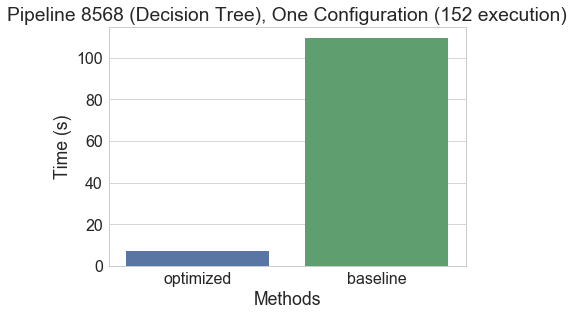

In [ ]:
ax = sns.barplot(x='method', y='time', data=result)
ax.set_xlabel('Methods')
ax.set_ylabel('Time (s)')
ax.set_title('Pipeline 8568 (Decision Tree), \nOne Configuration (152 execution)')

In [27]:
result

,method,time
0,optimized,7.461563
1,baseline,109.313272
